<a href="https://colab.research.google.com/github/Lucia1009/TFG-Red-neuronal-turbinas-eolicas/blob/desarrollo/prediccion_de_potencias_con_regresi%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install darts -q
!pip install dash -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math


from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import R2Score

import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go



In [ ]:
df=pd.read_csv('elvalle_reparto_saltos_sp75.csv', delimiter=";",decimal=".",skiprows = [1])

In [ ]:
df_filtrado=df[(df['TIME'] % 600==540)]
print(df_filtrado.shape)
print(df.shape)

# for col in df_filtrado:
#     print("\n",col, "\n", df_filtrado[col].unique())

(21600, 150)
(216000, 150)


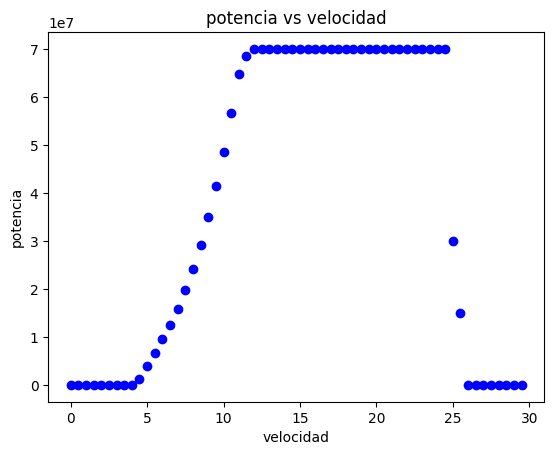

360


In [ ]:
# unique_wd, counts = np.unique(df_filtrado['wd'], return_counts=True)
# print(counts, "\n", unique_wd )

direcciones={}
for i in range(0,360):
    # Separo los datos para cada dirección
    filtered_data = df_filtrado[(df_filtrado['wd'] <= i) & (df_filtrado['wd'] > (i - 1 ))]

    # Selecciono solo las columnas que me interesan
    selected_columns = filtered_data[['ws', 'WF_Power', 'wd']]

    direcciones[i]=selected_columns
    # print(i, direcciones[i])

plt.title("potencia vs velocidad")
plt.scatter(direcciones[1]['ws'], direcciones[1]['WF_Power'], color="blue")

plt.xlabel("velocidad")
plt.ylabel("potencia")
plt.show()
print(len(direcciones))

In [ ]:
datos = pd.DataFrame(df_filtrado[['wd', 'ws', 'WF_Power']])

datos['sin_wd'] = np.sin(datos['wd']*np.pi/180)
datos['cos_wd'] = np.cos(datos['wd']*np.pi/180)
datos = datos.drop('wd', axis=1)


datos.tail()

,ws,WF_Power,sin_wd,cos_wd
215959,27.500000,1.157064e-41,-0.017452,0.999848
215969,28.000000,-1.711043e-52,-0.017452,0.999848
215979,28.500000,6.197535e-59,-0.017452,0.999848
215989,29.000000,7.481889e-71,-0.017452,0.999848
215999,29.500001,-1.019971e-84,-0.017452,0.999848






---

<br>


# Regresión polinómica

In [ ]:
datos_train = []
datos_test = []
for i in range(datos.shape[0]):

  if i%4==0:
      datos_test.append(datos.iloc[i])
  else:
      datos_train.append(datos.iloc[i])

print(len(datos_train), len(datos_test))
print(datos.shape[0]/len(datos_test))
print(datos.shape[0]/4)

print(datos_train[0], "\n", datos_train[1])

datos_train = pd.DataFrame(datos_train)
datos_test = pd.DataFrame(datos_test)

X_train_p = datos_train.drop('WF_Power', axis=1)
y_train_p = datos_train['WF_Power']

X_test_p = datos_test.drop('WF_Power', axis=1)
y_test_p = datos_test['WF_Power']

X_train_p.head(10)

16200 5400
4.0
5400.0
ws          5.000000e-01
WF_Power    2.704126e-41
sin_wd      0.000000e+00
cos_wd      1.000000e+00
Name: 19, dtype: float64 
 ws          1.000000e+00
WF_Power    1.847847e-58
sin_wd      0.000000e+00
cos_wd      1.000000e+00
Name: 29, dtype: float64


,ws,sin_wd,cos_wd
19,0.5,0.0,1.0
29,1.0,0.0,1.0
39,1.5,0.0,1.0
59,2.5,0.0,1.0
69,3.0,0.0,1.0
79,3.5,0.0,1.0
99,4.5,0.0,1.0
109,5.0,0.0,1.0
119,5.5,0.0,1.0
139,6.5,0.0,1.0


In [ ]:
# datos_x = datos.drop('WF_Power', axis=1)
# datos_y = datos['WF_Power']

# #Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
# X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(datos_x, datos_y, test_size=0.2 )

#Transformamos los datos
transformador = Pipeline([('scaler', StandardScaler()),  # normaliza los datos
                  ('poly', PolynomialFeatures(degree=15))]) ################ grado


X_train_p_transf  = transformador.fit_transform(X_train_p)
X_test_p_transf = transformador.transform(X_test_p)

print(X_train_p_transf.shape[1])

### Creamos el modelo ###

def build_model(input_shape):
  model_nn = keras.Sequential([
    keras.layers.Input(shape=(input_shape,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

  model_nn.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'R2Score'])
  return model_nn

model_nn = build_model(X_train_p_transf.shape[1])

#Entrenamos el modelo
model_nn.fit(X_train_p_transf, y_train_p, epochs=40, verbose=1)   ############## epochs

#Evaluamos el modelo
model_nn.evaluate(X_test_p_transf, y_test_p)


816
Epoch 1/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - R2Score: -1.5393 - loss: 2549894703218688.0000 - mae: 39336700.0000 - mse: 2549894703218688.0000
Epoch 2/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - R2Score: -1.4732 - loss: 2494379834998784.0000 - mae: 38906532.0000 - mse: 2494379834998784.0000
Epoch 3/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - R2Score: -1.3723 - loss: 2392406842408960.0000 - mae: 38353164.0000 - mse: 2392406842408960.0000
Epoch 4/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - R2Score: -1.1956 - loss: 2210424514674688.0000 - mae: 37193464.0000 - mse: 2210424514674688.0000
Epoch 5/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - R2Score: -0.9733 - loss: 1982160022011904.0000 - mae: 35406484.0000 - mse: 1982160022011904.0000
Epoch 6/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - R2Score: -0.6842 - loss: 1698275434430464.0000 - mae: 32512906.0000 - mse: 1698275434430464.0000
Epoch 7/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - R2Score: -0.4132 - loss: 14284069357

[32257072955392.0, 3654848.75, 32257072955392.0, 0.9686836004257202]

In [ ]:
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Gráfica de Potencia vs. Velocidad"),
    dcc.Input(
        id='angulo',
        type='number',
        value=0,
        placeholder='Introduce el ángulo'
    ),
    dcc.Graph(id='grafico-potencia-velocidad')
])

@app.callback(
    Output('grafico-potencia-velocidad', 'figure'),
    [Input('angulo', 'value')]
)
def update_graph(angulo):

    sin_angulo = np.sin(angulo * np.pi / 180)
    cos_angulo = np.cos(angulo * np.pi / 180)

    # Filtrar todos los datos (tanto entrenamiento como test) con el ángulo
    df_filtrado_datos = datos[(datos['sin_wd'] == sin_angulo) &
                              (datos['cos_wd'] == cos_angulo)]

    if not df_filtrado_datos.empty:
        # Ordenar por velocidad del viento (ws)
        df_filtrado_datos = df_filtrado_datos.sort_values(by='ws')
        y_filtrado_datos = df_filtrado_datos['WF_Power']

        # Filtrar los datos de test
        df_filtrado_graf = X_test_p[(X_test_p['sin_wd'] == sin_angulo) &
                                    (X_test_p['cos_wd'] == cos_angulo)]

        if not df_filtrado_graf.empty:
            y_filtrado = y_test_p.loc[df_filtrado_graf.index]

            # Transformar los datos filtrados para predicción
            df_filtrado_transf = transformador.transform(df_filtrado_graf)
            y_pred_filtrado = model_nn.predict(df_filtrado_transf)

            # Crear la gráfica con los datos reales y las predicciones
            fig = go.Figure()

            # Datos reales (puntos)
            fig.add_trace(go.Scatter(x=df_filtrado_graf['ws'], y=y_filtrado,
                                     mode='markers', name='Potencia real',
                                     marker=dict(color='blue')))

            # Predicciones (puntos)
            fig.add_trace(go.Scatter(x=df_filtrado_graf['ws'], y=y_pred_filtrado.flatten(),
                                     mode='markers', name='Potencia predicha',
                                     marker=dict(color='red')))

            # Línea continua para las predicciones
            rango_x = np.linspace(df_filtrado_graf['ws'].min(), df_filtrado_graf['ws'].max(), 100)

            # Crear un DataFrame para el rango
            rango_df = pd.DataFrame({'ws': rango_x, 'sin_wd': [sin_angulo] * 100, 'cos_wd': [cos_angulo] * 100})

            # Transformar el rango de x
            rango_x_transf = transformador.transform(rango_df)

            # Predicción de los valores en el rango
            rango_y_pred = model_nn.predict(rango_x_transf)
            fig.add_trace(go.Scatter(x=rango_x, y=rango_y_pred.flatten(), mode='lines', name='Línea predicción', line=dict(color='red')))

        # Interpolar una línea de los valores reales
        rango_y_real = np.interp(rango_x, df_filtrado_datos['ws'], y_filtrado_datos)

        # Línea continua para los valores reales
        fig.add_trace(go.Scatter(x=rango_x, y=rango_y_real, mode='lines', name='Línea real', line=dict(color='blue')))

        fig.update_layout(
            title="Potencia vs. Velocidad",
            xaxis_title="Velocidad del viento (ws)",
            yaxis_title="Potencia (WF_Power)"
        )

        return fig
    else:
        # Si no hay datos filtrados, devuelve una gráfica vacía
        return px.scatter(x=[], y=[],
                          labels={'x': 'Velocidad del viento (ws)', 'y': 'Potencia (WF_Power)'})


if __name__ == '__main__':
    app.run_server(debug=True, port=8053)


<IPython.core.display.Javascript object>

## Prueba hiperparámetros polinomial

In [ ]:
### Creamos el modelo ###

def build_model(input_shape):
  model_nn = keras.Sequential([
    keras.layers.Input(shape=(input_shape,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

  model_nn.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'R2Score'])
  return model_nn


# Definir los rangos de los hiperparámetros
param_grid = {
    'grado': [11, 13, 15],
    'epochs':[40]
}

best_mse = float('inf')
best_params = None

# Búsqueda manual de hiperparámetros
for grado in param_grid['grado']:
  for epochs in param_grid['epochs']:
    print(f"Probando grado={grado}, epoch={epochs}")

    #Transformamos los datos
    transformador = Pipeline([('scaler', StandardScaler()),  # normaliza los datos
                      ('poly', PolynomialFeatures(degree=grado))])


    X_train_p_transf  = transformador.fit_transform(X_train_p)
    X_test_p_transf = transformador.transform(X_test_p)

    print('shape',X_train_p_transf.shape[1])



    model_nn = build_model(X_train_p_transf.shape[1])

    #Entrenamos el modelo
    model_nn.fit(X_train_p_transf, y_train_p, epochs=epochs, verbose=0)

    #Evaluamos el modelo
    evaluacion=model_nn.evaluate(X_test_p_transf, y_test_p)


    mse = evaluacion[0]
    print(f"MSE: {mse}")

    # Guardar los mejores parámetros
    if mse < best_mse*1.1:
        best_mse = mse
        best_params =( grado, epochs)

# Mostrar los mejores hiperparámetros y el MSE asociado
print(f"Mejores parámetros: grado={best_params[0]}, epochs={best_params[1]} con MSE={best_mse}")



Probando grado=11, epoch=40
shape 364
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - R2Score: 0.9403 - loss: 61575301955584.0000 - mae: 5964789.5000 - mse: 61575301955584.0000
MSE: 62379387781120.0
Probando grado=13, epoch=40
shape 560
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - R2Score: 0.9654 - loss: 35688728756224.0000 - mae: 3896793.0000 - mse: 35688728756224.0000
MSE: 37788867100672.0
Probando grado=15, epoch=40
shape 816
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - R2Score: 0.9761 - loss: 24651315019776.0000 - mae: 3002296.0000 - mse: 24651315019776.0000
MSE: 27486060544000.0
Mejores parámetros: grado=15, epochs=40 con MSE=27486060544000.0




---

<br>

# Random forest

In [ ]:
!pip install tensorflow_decision_forests -q
!pip install wurlitzer -q
!pip install scikeras -q
!pip install keras-tuner -q


In [ ]:
import tensorflow_decision_forests as tfdf
import keras_tuner as kt
from wurlitzer import sys_pipes
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
# datos_train = []
# datos_test = []
# for i in range(datos.shape[0]):

#   if i%4==0:
#       datos_test.append(datos.iloc[i])
#   else:
#       datos_train.append(datos.iloc[i])

# print(len(datos_train), len(datos_test))
# print(datos.shape[0]/len(datos_test))
# print(datos.shape[0]/4)

# print(datos_train[0], "\n", datos_train[1])

# datos_train = pd.DataFrame(datos_train)
# datos_test = pd.DataFrame(datos_test)

# # Todas las columnas menos el label
# using_col_list = [col for col in datos_train.columns if col != 'WF_Power']
# print(using_col_list)

# feature_list = []
# for col in using_col_list:

#    feature_list.append(tfdf.keras.FeatureUsage(name=col,semantic=tfdf.keras.FeatureSemantic.NUMERICAL))

# trainds = tfdf.keras.pd_dataframe_to_tf_dataset(datos_train, label='WF_Power',task = tfdf.keras.Task.REGRESSION)
# testds = tfdf.keras.pd_dataframe_to_tf_dataset(datos_test, label='WF_Power',task = tfdf.keras.Task.REGRESSION)


['ws', 'sin_wd', 'cos_wd']


In [ ]:

#vuelvo a separar en conjuntos la variable datos
dftrain, dftest = train_test_split(datos, test_size=0.2)

# Todas las columnas menos el label
using_col_list = [col for col in dftrain.columns if col != 'WF_Power']
print(using_col_list)

feature_list = []
for col in using_col_list:

   feature_list.append(tfdf.keras.FeatureUsage(name=col,semantic=tfdf.keras.FeatureSemantic.NUMERICAL))

trainds = tfdf.keras.pd_dataframe_to_tf_dataset(dftrain, label='WF_Power',task = tfdf.keras.Task.REGRESSION)
testds = tfdf.keras.pd_dataframe_to_tf_dataset(dftest, label='WF_Power',task = tfdf.keras.Task.REGRESSION)


['ws', 'sin_wd', 'cos_wd']


In [ ]:
model_rf = tfdf.keras.RandomForestModel(features = feature_list, task = tfdf.keras.Task.REGRESSION,
                                    #exclude_non_specified_features=True, #innsecesario porque ya hemos quitado el label
                                    num_trees=150, max_depth=10,
                                    split_axis="SPARSE_OBLIQUE",categorical_algorithm="RANDOM",
                                    missing_value_policy='RANDOM_LOCAL_IMPUTATION',
                                    sparse_oblique_normalization='STANDARD_DEVIATION',
                                    compute_oob_variable_importances=True,
                                    winner_take_all=False)
model_rf.compile(metrics=["Accuracy"])

with sys_pipes():
    model_rf.fit(trainds)

Use /tmp/tmp7o8p2l89 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.814083. Found 17280 examples.
Training model...


I0000 00:00:1729761246.177100   24449 kernel.cc:774] Start Yggdrasil model training
I0000 00:00:1729761246.177442   24449 kernel.cc:775] Collect training examples
I0000 00:00:1729761246.177479   24449 kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
column_guides {
  column_name_pattern: "^ws$"
  type: NUMERICAL
}
column_guides {
  column_name_pattern: "^sin_wd$"
  type: NUMERICAL
}
column_guides {
  column_name_pattern: "^cos_wd$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1729761246.177723   24449 kernel.cc:394] Number of batches: 18
I0000 00:00:1729761246.177743   24449 kernel.cc:395] Number of examples: 17280
I0000 00:00:1729761246.188009   24449 kernel.cc:794] Training dataset:
Number of records: 17280
Number of columns: 4

Number

Model trained in 0:00:20.196362
Compiling model...
Model compiled.


In [ ]:
inspector = model_rf.make_inspector()
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
    print("\t", importance)

Available variable importances:
	 NUM_NODES
	 SUM_SCORE
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 MEAN_INCREASE_IN_RMSE


In [ ]:
inspector.variable_importances()["MEAN_INCREASE_IN_RMSE"]

[("ws" (1; #3), 26234812.25),
 ("cos_wd" (1; #1), 2153462.25),
 ("sin_wd" (1; #2), 1026246.0)]

In [ ]:
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Gráfica de Potencia vs. Velocidad"),
    dcc.Input(
        id='angulo',
        type='number',
        value=0,
        placeholder='Introduce el ángulo'
    ),
    dcc.Graph(id='grafico-potencia-velocidad')
])

@app.callback(
    Output('grafico-potencia-velocidad', 'figure'),
    [Input('angulo', 'value')]
)
def update_graph(angulo):

    sin_angulo_val = np.sin(angulo * np.pi / 180)
    cos_angulo_val = np.cos(angulo * np.pi / 180)

    # Filtrar todos los datos con base en el ángulo
    datos_filtrados_total = datos[(np.isclose(datos['sin_wd'], sin_angulo_val)) &
                                  (np.isclose(datos['cos_wd'], cos_angulo_val))]

    # Comprobar si el filtrado contiene datos
    if not datos_filtrados_total.empty:
        # Ordenar por velocidad del viento (ws)
        datos_filtrados_total = datos_filtrados_total.sort_values(by='ws')
        y_filtrados_total = datos_filtrados_total['WF_Power']

        # Filtrar los datos de test
        datos_filtrados_graf = dftest[(np.isclose(dftest['sin_wd'], sin_angulo_val)) &
                                      (np.isclose(dftest['cos_wd'], cos_angulo_val))]

        # Crear la gráfica solo si hay datos filtrados de test
        if not datos_filtrados_graf.empty:
            y_filtrado_graf = datos_filtrados_graf['WF_Power']

            # Convertimos a dataset de TensorFlow Decision Forests
            test_df_transf_graf = tfdf.keras.pd_dataframe_to_tf_dataset(datos_filtrados_graf, task=tfdf.keras.Task.REGRESSION)

            # Hacer predicciones con el modelo
            try:
                y_pred_filtrado_graf = model_rf.predict(test_df_transf_graf)
            except Exception as e:
                print(f"Error en la predicción: {e}")
                return px.scatter(x=[], y=[], labels={'x': 'Velocidad del viento (ws)', 'y': 'Potencia (WF_Power)'})

            # Crear la gráfica con los datos reales y las predicciones
            fig = go.Figure()

            # Datos reales (puntos)
            fig.add_trace(go.Scatter(x=datos_filtrados_graf['ws'], y=y_filtrado_graf,
                                     mode='markers', name='Potencia real',
                                     marker=dict(color='blue')))

            # Predicciones (puntos)
            fig.add_trace(go.Scatter(x=datos_filtrados_graf['ws'], y=y_pred_filtrado_graf.flatten(),
                                     mode='markers', name='Potencia predicha',
                                     marker=dict(color='red')))

            # Línea continua para las predicciones
            rango_x_graf = np.linspace(datos_filtrados_graf['ws'].min(), datos_filtrados_graf['ws'].max(), 100)

            # Crear un DataFrame para el rango
            rango_df_graf = pd.DataFrame({'ws': rango_x_graf, 'sin_wd': [sin_angulo_val] * 100, 'cos_wd': [cos_angulo_val] * 100})

            # Convertir rango_df_graf en dataset
            rango_df_transf_graf = tfdf.keras.pd_dataframe_to_tf_dataset(rango_df_graf, task=tfdf.keras.Task.REGRESSION)

            # Predicción de los valores en el rango
            try:
                rango_y_pred_graf = model_rf.predict(rango_df_transf_graf)
                fig.add_trace(go.Scatter(x=rango_x_graf, y=rango_y_pred_graf.flatten(), mode='lines', name='Línea predicción', line=dict(color='red')))
            except Exception as e:
                print(f"Error en la predicción del rango: {e}")

        # Interpolación de los valores reales
        rango_y_real_graf = np.interp(rango_x_graf, datos_filtrados_total['ws'], y_filtrados_total)

        # Línea continua para los valores reales
        fig.add_trace(go.Scatter(x=rango_x_graf, y=rango_y_real_graf, mode='lines', name='Línea real', line=dict(color='blue')))

        fig.update_layout(
            title="Potencia vs. Velocidad",
            xaxis_title="Velocidad del viento (ws)",
            yaxis_title="Potencia (WF_Power)"
        )

        return fig
    else:
        # Si no hay datos filtrados, devuelve una gráfica vacía
        return px.scatter(x=[], y=[],
                          labels={'x': 'Velocidad del viento (ws)', 'y': 'Potencia (WF_Power)'})

if __name__ == '__main__':
    app.run_server(debug=True, port=8051)



<IPython.core.display.Javascript object>

## Prueba de hiperparámetros random forest

In [ ]:
#vuelvo a separar en conjuntos la variable datos
dftrain, dftest = train_test_split(datos, test_size=0.2)

# Todas las columnas menos el label
using_col_list = [col for col in dftrain.columns if col != 'WF_Power']
print(using_col_list)

feature_list = []
for col in using_col_list:

   feature_list.append(tfdf.keras.FeatureUsage(name=col,semantic=tfdf.keras.FeatureSemantic.NUMERICAL))

trainds = tfdf.keras.pd_dataframe_to_tf_dataset(dftrain, label='WF_Power',task = tfdf.keras.Task.REGRESSION)
testds = tfdf.keras.pd_dataframe_to_tf_dataset(dftest, label='WF_Power',task = tfdf.keras.Task.REGRESSION)


['ws', 'sin_wd', 'cos_wd']


In [ ]:
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Dividir los datos en entrenamiento y prueba
dftrain, dftest = train_test_split(datos, test_size=0.2)

# Todas las columnas menos el label
using_col_list = [col for col in dftrain.columns if col != 'WF_Power']

feature_list = []
for col in using_col_list:
    feature_list.append(tfdf.keras.FeatureUsage(name=col, semantic=tfdf.keras.FeatureSemantic.NUMERICAL))

# Convertir los datos a datasets de TensorFlow para TFDF
trainds = tfdf.keras.pd_dataframe_to_tf_dataset(dftrain, label='WF_Power', task=tfdf.keras.Task.REGRESSION)
testds = tfdf.keras.pd_dataframe_to_tf_dataset(dftest, label='WF_Power', task=tfdf.keras.Task.REGRESSION)

# Definir los rangos de los hiperparámetros
param_grid = {
    'num_trees': [ 100, 200, 300],
    'max_depth': [6, 8, 10]
}

best_mse = float('inf')
best_params = None

# Búsqueda manual de hiperparámetros
for num_trees in param_grid['num_trees']:
    for max_depth in param_grid['max_depth']:
        print(f"Probando num_trees={num_trees}, max_depth={max_depth}")

        # Crear el modelo
        model_rf = tfdf.keras.RandomForestModel(
            features=feature_list,
            task=tfdf.keras.Task.REGRESSION,
            num_trees=num_trees,
            max_depth=max_depth,
            split_axis="SPARSE_OBLIQUE",
            categorical_algorithm="RANDOM",
            missing_value_policy='RANDOM_LOCAL_IMPUTATION',
            sparse_oblique_normalization='STANDARD_DEVIATION',
            compute_oob_variable_importances=True,
            winner_take_all=False
        )

        # Entrenar el modelo
        model_rf.fit(trainds)

        # Predecir y evaluar el rendimiento
        predictions = model_rf.predict(testds)
        mse = mean_squared_error(dftest['WF_Power'], predictions)
        print(f"MSE: {mse}")

        # Guardar los mejores parámetros
        if mse < best_mse*1.1:
            best_mse = mse
            best_params = (num_trees, max_depth)

# Mostrar los mejores hiperparámetros y el MSE asociado
print(f"Mejores parámetros: num_trees={best_params[0]}, max_depth={best_params[1]} con MSE={best_mse}")


Probando num_trees=100, max_depth=6
Use /tmp/tmp08m3oyl6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.279620. Found 17280 examples.
Training model...
Model trained in 0:00:08.402550
Compiling model...
Model compiled.
5/5 [==============================] - 0s 10ms/step
MSE: 12288738041984.645
Probando num_trees=100, max_depth=8
Use /tmp/tmpiuzm62e0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.279558. Found 17280 examples.
Training model...
Model trained in 0:00:07.599411
Compiling model...
Model compiled.
5/5 [==============================] - 0s 34ms/step
MSE: 6971124008355.5625
Probando num_trees=100, max_depth=10
Use /tmp/tmp_4jzlzac as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.400656. Found 17280 examples.
Training model...
Model trained in 0:00:12.076061
Compiling model...
Model compiled.
5/5 [==============================] - 0s 22ms/step




---

<br>

# Prueba de los modelos sobre las potencias de cada turbina

In [ ]:
print(datos.columns)
df_filtrado
model_nn.predict()
model_rf.predict()

Index(['ws', 'WF_Power', 'sin_wd', 'cos_wd'], dtype='object')


TypeError: TensorFlowTrainer.predict() missing 1 required positional argument: 'x'